**EXP3 Predicitng Missing Cell-Types from Bulks using CIBERSORTx Residual**

*This file includes EXP2 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

Code based on:
1. https://github.com/greenelab/sc_bulk_ood/blob/main/sc_preprocessing/0_qc_notebooks/scanpy_analysis_pbmc6k.ipynb
2. https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE176171
Original paper: https://pubmed.ncbi.nlm.nih.gov/35296864/ PMID: 35296864

Experimental Details: https://docs.google.com/spreadsheets/d/1fMV_URm95iPh-6rew-Be27I1-i8PNgGNWi2D_UO2V9w/edit#gid=0

Summary: Preprocessed data used to create multiple pseudobulk files in previous notebooks. Here we import those random-proportion bulks and prepare files to be run in EXP2_bayesprism_pbmc.R.

*This file can be run one kernel at a time, or all at once*

In [106]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import celltypist
from celltypist import models

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import umap
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [107]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_adp_EXP3"
pseudos_name = "MCT_adp_EXP3"
path = f"/../data/"
aug_data_path = "/../data/EXP3/"
data_path = "/../data/EXP3/cibersort/"
#noise_type 
nt = "noise" #[no noise, noise]
bulk_type = "realistic"  # [realistic, random]
random_seed = 88
bulks_type = f"{bulk_type}prop_{nt}"

## **Reading and QCing the data:**

In [108]:
actual_path = os.getcwd()
path = f"{actual_path}{path}"
aug_data_path = f"{actual_path}{aug_data_path}"
data_path = f"{actual_path}{data_path}"

In [109]:
#this is just for QC
sc_adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_notlog.h5ad")
print(sc_adata_path)
sc_adata_path = Path(sc_adata_path)
sc_adata = sc.read_h5ad(sc_adata_path)
sc_adata

/Users/ivicha/Documents/Project_missingcelltype/pred_missing_celltypes/preprocessing/../data/EXP3/MCT_adp_EXP3_scadata_notlog.h5ad


AnnData object with n_obs × n_vars = 18490 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [110]:
sn_prop = vp.make_prop_table(sc_adata, "cell_types")
sn_prop

,Cell_Types,Num_Cells,Prop_Cells
0,dendritic cell,983,0.053164
1,monocyte,636,0.034397
2,preadipocyte,13461,0.728015
3,endothelial cell of lymphatic vessel,157,0.008491
4,macrophage,1410,0.076257
5,T cell,807,0.043645
6,endothelial cell,542,0.029313
7,immature NK T cell,389,0.021038
8,pericyte cell,52,0.002812
9,mast cell,53,0.002866


In [111]:
#this is just for QC
sn_adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_notlog.h5ad")
print(sn_adata_path)
sn_adata_path = Path(sn_adata_path)
sn_adata = sc.read_h5ad(sn_adata_path)
sn_adata

/Users/ivicha/Documents/Project_missingcelltype/pred_missing_celltypes/preprocessing/../data/EXP3/MCT_adp_EXP3_snadata_notlog.h5ad


AnnData object with n_obs × n_vars = 113017 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [112]:
sn_prop = vp.make_prop_table(sn_adata, "cell_types")
sn_prop

,Cell_Types,Num_Cells,Prop_Cells
0,mesothelial cell,26276,0.232496
1,fat cell,24825,0.219657
2,macrophage,13625,0.120557
3,preadipocyte,26941,0.238380
4,endothelial cell,11480,0.101578
5,endothelial cell of lymphatic vessel,2339,0.020696
6,pericyte cell,1165,0.010308
7,T cell,3022,0.026739
8,dendritic cell,679,0.006008
9,mast cell,883,0.007813


QC imported dataset:

In [113]:
#QC that it is not normalized
sc_adata.X.max()

1558.0

         Falling back to preprocessing with `sc.pp.pca` and default params.


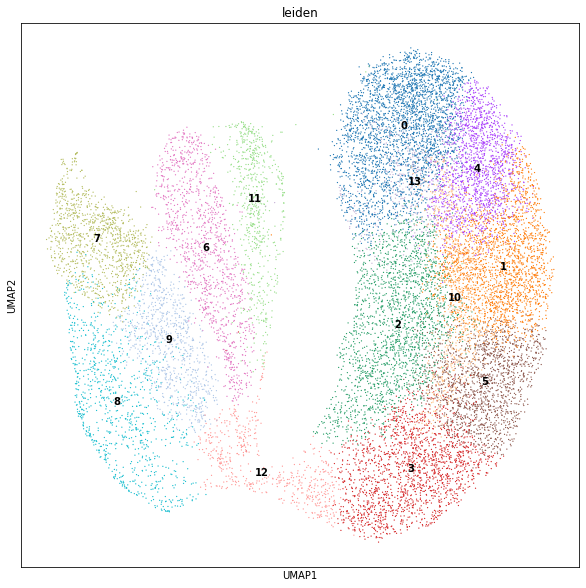

In [114]:
# lets use Leiden clustering
sc.pp.neighbors(sc_adata)
sc.tl.umap(sc_adata)
sc.tl.leiden(sc_adata, resolution=0.8)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(sc_adata, color='leiden', legend_loc='on data')

In [115]:
Counter(sc_adata.obs["cell_types"])

Counter({'dendritic cell': 983,
         'monocyte': 636,
         'preadipocyte': 13461,
         'endothelial cell of lymphatic vessel': 157,
         'macrophage': 1410,
         'T cell': 807,
         'endothelial cell': 542,
         'immature NK T cell': 389,
         'pericyte cell': 52,
         'mast cell': 53})

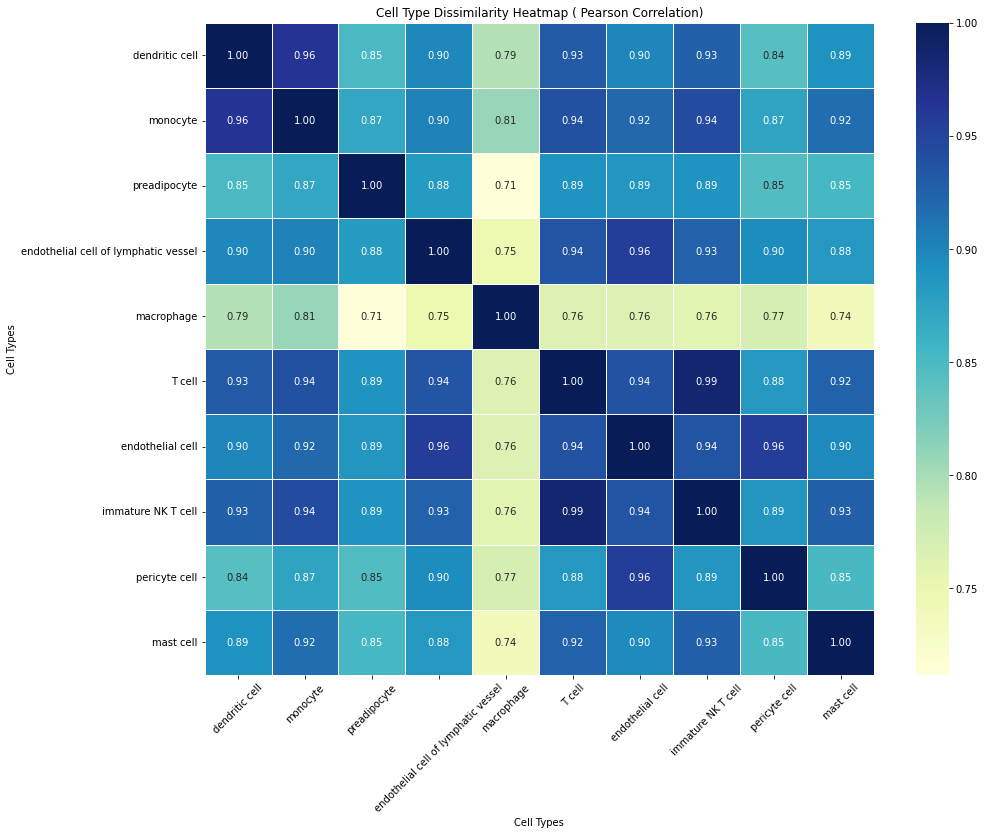

In [116]:
# Define the number of samples for resampling
num_samples = 10000

# Making cell type reference without scaling
cell_types = sc_adata.obs["cell_types"].unique()
gene_ids = sc_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = sc_adata[sc_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

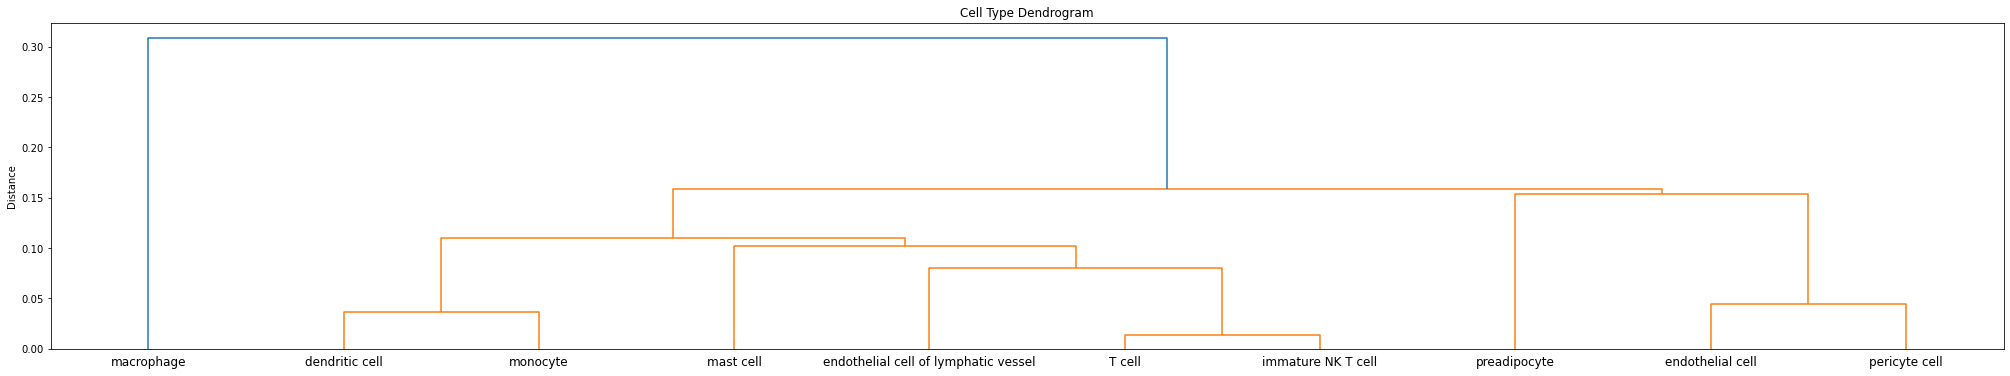

In [117]:
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(35, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()

In [118]:
sc_adata.obs["scpred_CellType"] = sc_adata.obs["cell_types"]

Cell Types are already missing from reference, so importing Pseudobulks

## **Importing and QCing Pseudobulks**

In [119]:
#using SN because that's the data from which the pseudobulks were created
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

1200

In [120]:
X_full, Y_full, gene_df, meta_df= sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type=f"{nt}_", file_name = pseudos_name, num_bulks_training = num_bulks, num_files=10, random_selection = False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1
2
3
4
5
6
7
8
9


(8000, 2)
(8000, 2)


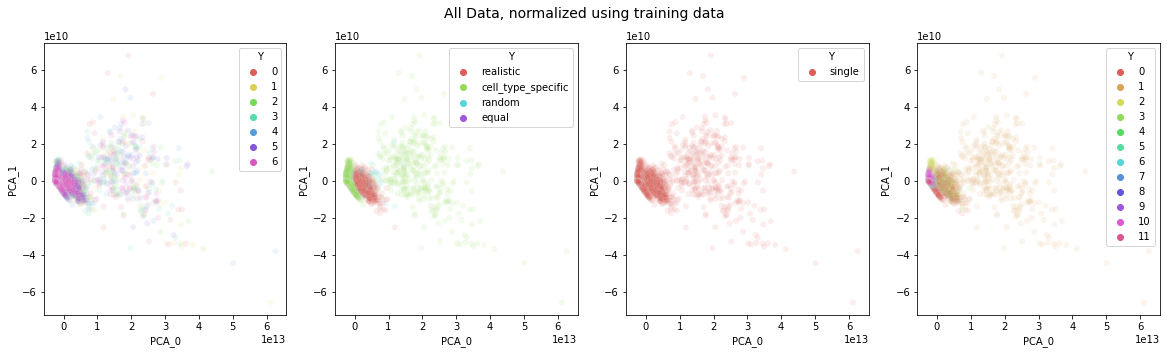

In [121]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.107s...
[t-SNE] Computed neighbors for 8000 samples in 20.010s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 4989607420.828942
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.104759
[t-SNE] KL divergence after 500 iterations: 0.660170
(8000, 2)
(8000, 2)


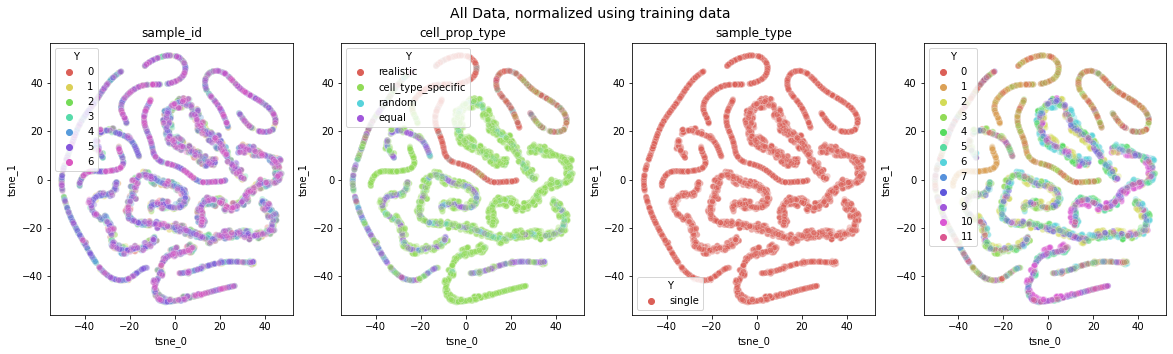

In [122]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_tsne_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"sample_id")
vp.plot_tsne(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"cell_prop_type")
vp.plot_tsne(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"sample_type")
vp.plot_tsne(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)
fig.show()

In [123]:
#cut to only the random samples
idx_interest = np.where(meta_df.cell_prop_type == bulk_type)[0]
pseudos_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudos_df.index = range(0,len(pseudos_df))
prop_df.index = pseudos_df.index
meta_df.index = meta_df.index
pseudos_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,1735.495428,8079.411578,437.195256,6.815863e+06,8009.558819,3000.531303,272532.738423,104.260046,53453.744098,139.801013,...,0.000000,9.884674,0.00000,0.000000,0.000000,0.000000,6.163890,0.0,0.000000,0.000000
1,1537.419948,11155.108808,89.865600,5.640153e+06,18919.646160,1880.963520,419506.177563,228.372816,58816.653150,45.976711,...,0.000000,0.000000,0.00000,6.304355,0.000000,1.527034,3.085811,0.0,1.038864,0.000000
2,1187.690444,10745.134881,348.544620,2.395917e+06,7542.105953,2748.602540,498204.328352,506.104890,38420.346998,115.001562,...,0.000000,0.000000,0.00000,0.000000,1.014438,0.000000,0.000000,0.0,2.559374,0.000000
3,3386.356334,14963.222473,70.712264,7.245391e+06,9663.799556,2666.471418,668273.603735,276.741968,46039.690506,12.398503,...,0.000000,0.000000,0.00000,0.856907,0.000000,0.000000,0.000000,0.0,7.047741,0.000000
4,2289.703889,15077.416080,232.477803,8.605425e+06,11544.226282,1712.212313,201814.237898,282.925306,47515.432287,50.729113,...,4.090845,0.000000,2.82749,0.791035,0.000000,0.972021,0.000000,0.0,11.686691,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1897.595749,10703.099840,100.250529,1.164767e+07,17233.138278,3822.214853,526090.511590,296.434265,109533.450027,33.927004,...,0.000000,0.000000,0.00000,0.000000,2.774353,0.000000,0.000000,0.0,0.000000,0.000000
1996,731.360683,9866.616307,383.549538,1.790424e+07,17239.542393,2208.704622,814836.748845,161.786213,83157.256652,181.186487,...,0.000000,2.384239,0.00000,0.000000,0.000000,2.058290,1.118449,0.0,0.000000,0.000000
1997,1916.351486,19089.477064,549.846483,1.037639e+07,9612.391990,3445.454132,370886.571206,482.657619,48338.834301,41.029057,...,0.000000,0.000000,0.00000,9.591892,0.000000,0.000000,0.000000,0.0,8.477524,0.000000
1998,1709.837341,12455.761750,249.787619,3.062732e+06,10103.655040,4323.073680,633592.153676,92.935946,21851.221924,28.602230,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.725669,1.157632


In [124]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudos_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudos_df = pseudos_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudos_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
1059,1184.841929,7740.805478,113.917190,1.261270e+07,6764.178696,3798.866665,353820.702740,355.444152,80976.957229,71.805229,...,0.000000,0.000000,0.000000,0.000000,0.907108,0.000000,0.000000,3.071833,3.355255,0.000000
929,2188.593289,9097.040557,180.377439,7.803219e+06,20007.675484,1299.823965,545090.934930,79.500708,32551.224337,52.444160,...,3.135887,0.000000,0.978023,0.000000,3.830455,0.000000,0.000000,0.000000,16.143834,0.000000
1506,2292.491293,15029.296567,145.429987,6.659730e+06,15817.844250,2474.244132,557679.918019,403.095987,63444.769003,92.969155,...,1.164352,0.000000,0.000000,0.000000,0.000000,2.381197,0.960018,0.000000,3.479216,0.000000
237,4466.068174,14601.576413,152.076261,1.606157e+07,53495.822581,3491.228030,579085.856067,125.118911,77512.815639,114.860084,...,0.000000,0.000000,0.000000,5.314167,3.457105,0.000000,0.000000,0.000000,0.000000,2.968435
1371,1531.722357,9001.318170,1082.674525,1.130663e+07,15198.853330,3488.425483,689016.569902,146.447995,39106.625573,277.338378,...,0.000000,1.029058,0.000000,0.000000,5.941948,1.079052,0.000000,0.000000,2.494453,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,2202.688539,16803.839184,63.681946,4.974987e+06,8629.735529,1297.804461,424169.682007,101.390355,37800.727980,22.833778,...,0.000000,3.242908,0.000000,0.000000,0.000000,0.000000,0.876849,0.000000,10.214296,0.000000
1132,1507.773605,11908.419776,184.551713,2.193898e+06,6574.144488,1848.352813,383842.624060,43.044835,15453.525688,88.456961,...,0.000000,0.000000,0.000000,3.090790,0.000000,0.000000,0.000000,0.000000,3.840724,0.000000
1998,1709.837341,12455.761750,249.787619,3.062732e+06,10103.655040,4323.073680,633592.153676,92.935946,21851.221924,28.602230,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.725669,1.157632
1988,2143.241661,9083.718061,288.565155,3.951749e+06,5977.536290,6045.852554,574807.972465,456.657038,67588.747978,0.000000,...,0.000000,0.000000,0.000000,1.929001,0.000000,0.866535,0.000000,0.000000,1.084996,0.000000


Putting together all reference expression and proportions.

First, with single cell (missing 2):

Limiting Cell Type number for computation:

In [125]:
cell_order = prop_df.columns

In [126]:
#import anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_notlog.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)

cell_types_to_limit = cell_order
#define the cell types to limit and the desired maximum number of cells
max_cells_per_type = 1000

#dreate a mask to identify cells from the cell types to limit
mask_to_limit = adata.obs["cell_types"].isin(cell_types_to_limit)

#create a mask for the remaining cell types
mask_remaining = ~mask_to_limit

#initialize a dictionary to keep track of removed cells per cell type
removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

#initialize arrays to store new observations and filtered indices
new_obs = []
filtered_indices = []

#iterate through each cell in the original sn_adata object
for cell_idx, cell_type in enumerate(adata.obs["cell_types"]):
    if cell_type in cell_types_to_limit:
        removed_count = removed_cells_count.get(cell_type, 0)
        if removed_count < max_cells_per_type:
            removed_cells_count[cell_type] = removed_count + 1
            filtered_indices.append(cell_idx)

#create a new AnnData object with the filtered cells
filtered_sc_adata = sc.AnnData(
    X=adata.X[filtered_indices],
    obs=adata.obs.iloc[filtered_indices],
    var=adata.var
)

#cppend the remaining cell types to the filtered sn_adata object
filtered_sc_adata = filtered_sc_adata.concatenate(
    adata[mask_remaining],
    join="outer"
)
#QC
print(Counter(filtered_sc_adata.obs.cell_types))
#save as anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
filtered_sc_adata.write_h5ad(adata_path)

... storing 'cell_types' as categorical


Counter({'preadipocyte': 1000, 'macrophage': 1000, 'dendritic cell': 983, 'T cell': 807, 'monocyte': 636, 'endothelial cell': 542, 'immature NK T cell': 389, 'endothelial cell of lymphatic vessel': 157, 'mast cell': 53, 'pericyte cell': 52})


In [127]:
dense_matrix = filtered_sc_adata.X.todense()

dense_df = pd.DataFrame(dense_matrix, columns = filtered_sc_adata.var['gene_ids'])
dense_df.insert(loc=0, column='cell_types', value=filtered_sc_adata.obs["cell_types"].to_list())

In [128]:
sc_cell_types = vp.make_prop_table(sc_adata, "cell_types")
sc_cell_types = sc_cell_types.drop(axis=0, index = len(sc_cell_types)-1)
sc_cell_types = sc_cell_types.sort_values('Cell_Types')
sc_cell_types = sc_cell_types.reindex()
sc_cell_types

,Cell_Types,Num_Cells,Prop_Cells
5,T cell,807,0.043645
0,dendritic cell,983,0.053164
6,endothelial cell,542,0.029313
3,endothelial cell of lymphatic vessel,157,0.008491
7,immature NK T cell,389,0.021038
4,macrophage,1410,0.076257
9,mast cell,53,0.002866
1,monocyte,636,0.034397
8,pericyte cell,52,0.002812
2,preadipocyte,13461,0.728015


In [129]:
sn_cell_types = vp.make_prop_table(sn_adata, "cell_types")
sn_cell_types = sn_cell_types.drop(axis=0, index = len(sn_cell_types)-1)
sn_cell_types = sn_cell_types.sort_values('Cell_Types')
sn_cell_types = sn_cell_types.reindex()
sn_cell_types

,Cell_Types,Num_Cells,Prop_Cells
7,T cell,3022,0.026739
8,dendritic cell,679,0.006008
4,endothelial cell,11480,0.101578
5,endothelial cell of lymphatic vessel,2339,0.020696
1,fat cell,24825,0.219657
11,immature NK T cell,1073,0.009494
2,macrophage,13625,0.120557
9,mast cell,883,0.007813
0,mesothelial cell,26276,0.232496
10,monocyte,709,0.006273


In [130]:
#matching proportion in reference (made from SC cells) to SN proportions
new_dense = pd.DataFrame(columns=dense_df.columns)
for cell_type in sn_cell_types["Cell_Types"]:
    idx_in_mat = sn_cell_types[sn_cell_types['Cell_Types'] == str(cell_type)].index[0]
    all_cells_from_type = dense_df[dense_df["cell_types"] == cell_type].index
    size = sn_cell_types['Num_Cells'].loc[idx_in_mat]
    if size > 1000:
        size = 1000
    if all_cells_from_type.shape != (0,):  
        if len(all_cells_from_type) < size:
            rep = True
        else:
            rep = False    
        random_idx = np.random.choice(all_cells_from_type, size=size, replace=rep)
        old_dense = dense_df.loc[random_idx]
        new_dense = pd.concat([new_dense, old_dense])
new_dense

gene_ids,cell_types,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,...,ULBP1,WTH3DI,XIRP1,Z82196.2,Z84488.1,Z99755.2,Z99916.3,ZNF280A,ZPBP2,CD99.Y
2658,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3146,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2917,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3816,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5412,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1383,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1327,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
dense_df = new_dense.sort_index()
dense_df

gene_ids,cell_types,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,...,ULBP1,WTH3DI,XIRP1,Z82196.2,Z84488.1,Z99755.2,Z99916.3,ZNF280A,ZPBP2,CD99.Y
0,dendritic cell,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,endothelial cell of lymphatic vessel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5616,mast cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5616,mast cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5616,mast cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5617,immature NK T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
#qc
#save file
dense_df.index = dense_df["cell_types"]
#does not have the cell types from SN
print(Counter(dense_df["cell_types"]))
dense_df.pop("cell_types")
sig_df_sn = dense_df

Counter({'preadipocyte': 1000, 'endothelial cell of lymphatic vessel': 1000, 'macrophage': 1000, 'T cell': 1000, 'endothelial cell': 1000, 'immature NK T cell': 1000, 'pericyte cell': 1000, 'mast cell': 883, 'monocyte': 709, 'dendritic cell': 679})


In [133]:
#details
exp_id = f"{res_name}"
patient_idx = f"{bulk_type}"
#and create files for CIBERSORTX
mix, sig = sn_sc_preprocess.write_cibersortx_files(bp_path = data_path, out_file_id = exp_id, 
                        sig_df= sig_df_sn, X_train = pseudos_df, num_str = '2', bulks_type = bulks_type)

(26672, 9271)


Mixture (pseudobulks):

In [134]:
# mix contains all pseudobulks
sc_profile_file = os.path.join(data_path, f"{exp_id}_{bulks_type}_mixture.txt")
sc_profile_path = Path(sc_profile_file)
mix.to_csv(sc_profile_path, sep = '\t', index= True)

In [135]:
#and proportions
# mix contains all pseudobulks
prop_profile_file = os.path.join(data_path, f"{exp_id}_{bulks_type}_prop.txt")
prop_profile_path = Path(prop_profile_file)
prop_df.to_csv(prop_profile_path, sep = '\t', index= True)

And now for single nucleus (0 missing):

In [136]:
#import anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_notlog.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)

cell_types_to_limit = cell_order
#define the cell types to limit and the desired maximum number of cells
max_cells_per_type = 700

#dreate a mask to identify cells from the cell types to limit
mask_to_limit = adata.obs["cell_types"].isin(cell_types_to_limit)

#create a mask for the remaining cell types
mask_remaining = ~mask_to_limit

#initialize a dictionary to keep track of removed cells per cell type
removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

#initialize arrays to store new observations and filtered indices
new_obs = []
filtered_indices = []

#iterate through each cell in the original sn_adata object
for cell_idx, cell_type in enumerate(adata.obs["cell_types"]):
    if cell_type in cell_types_to_limit:
        removed_count = removed_cells_count.get(cell_type, 0)
        if removed_count < max_cells_per_type:
            removed_cells_count[cell_type] = removed_count + 1
            filtered_indices.append(cell_idx)

#create a new AnnData object with the filtened cells
filtered_sn_adata = sc.AnnData(
    X=adata.X[filtered_indices],
    obs=adata.obs.iloc[filtered_indices],
    var=adata.var
)

#cppend the remaining cell types to the filtered sn_adana object
filtered_sn_adata = filtered_sn_adata.concatenate(
    adata[mask_remaining],
    join="outer"
)
#QC
print(Counter(filtered_sn_adata.obs.cell_types))
#save as anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
filtered_sn_adata.write_h5ad(adata_path)

... storing 'cell_types' as categorical


Counter({'mesothelial cell': 700, 'fat cell': 700, 'macrophage': 700, 'preadipocyte': 700, 'endothelial cell': 700, 'endothelial cell of lymphatic vessel': 700, 'pericyte cell': 700, 'T cell': 700, 'mast cell': 700, 'monocyte': 700, 'immature NK T cell': 700, 'dendritic cell': 679})


In [137]:
dense_matrix = filtered_sn_adata.X.todense()

dense_df = pd.DataFrame(dense_matrix, columns = filtered_sn_adata.var['gene_ids'])
dense_df.insert(loc=0, column='cell_types', value=filtered_sn_adata.obs["cell_types"].to_list())
#qc
#save file
dense_df.index = dense_df["cell_types"]
dense_df.pop("cell_types")
sig_df_sn = dense_df

In [138]:
dense_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
cell_types,,,,,,,,,,,,,,,,,,,,,
mesothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fat cell,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fat cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mesothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fat cell,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dendritic cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
#details
exp_id = f"{res_name}"
patient_idx = f"{bulk_type}"
#and create files for CIBERSORTX
mix, sig = sn_sc_preprocess.write_cibersortx_files(bp_path = data_path, out_file_id = exp_id, 
                        sig_df= sig_df_sn, X_train = pseudos_df, num_str = '0', bulks_type = bulks_type)

(28242, 8379)


In [140]:
sig

cell_types,mesothelial cell,fat cell,fat cell,mesothelial cell,fat cell,mesothelial cell,mesothelial cell,macrophage,mesothelial cell,mesothelial cell,...,monocyte,dendritic cell,monocyte,monocyte,monocyte,monocyte,monocyte,dendritic cell,dendritic cell,dendritic cell
gene_ids,,,,,,,,,,,,,,,,,,,,,
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
A2M-AS1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL049555.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL109945.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HIST1H3G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
